<a href="https://colab.research.google.com/github/advaithm22/MaterialClassification/blob/main/OfficialMaterialRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks'
/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip test.zip

In [ ]:
#!unzip train.zip

In [ ]:
#rootdir = 'drive/MyDrive/Colab Notebooks/FMD/image' #path of the original folder
classes = ['fabric', 'foliage', 'glass','leather', 'metal', 'paper', 'metal', 'plastic', 'stone', 'water', 'wood']


In [ ]:
#for i in classes:
    #os.makedirs(rootdir +'/train/' + i,exist_ok=True)

    #os.makedirs(rootdir +'/test/' + i,exist_ok=True)

    #source = rootdir + '/' + i

    #allFileNames = os.listdir(source)

    #np.random.shuffle(allFileNames)

    #test_ratio = 0.25

    #train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                      #[int(len(allFileNames)* (1 - test_ratio))])

    #train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
    #test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

    #for name in train_FileNames:
      #shutil.copy(name, rootdir +'/train/' + i)

    #for name in test_FileNames:
      #shutil.copy(name, rootdir +'/test/' + i)

In [ ]:
train_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/FMD', 'train')
validation_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/FMD', 'test')


In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             label_mode="int",
                                             labels="inferred",
                                             color_mode="rgb",
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                             label_mode="int",
                                             labels="inferred",
                                             color_mode="rgb",
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 769 files belonging to 10 classes.
Found 273 files belonging to 10 classes.


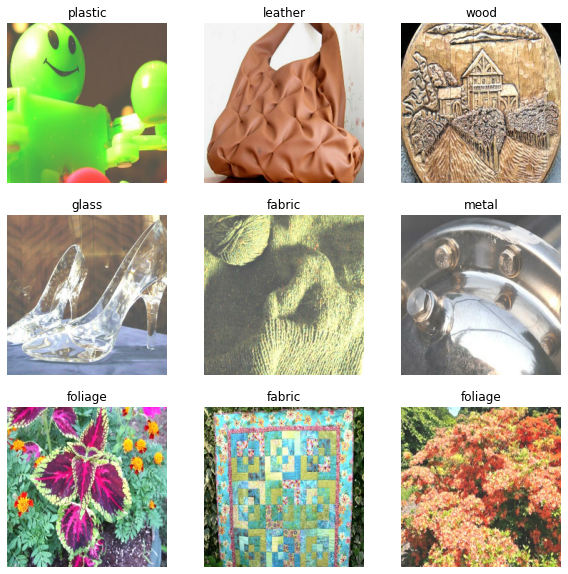

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 4
Number of test batches: 1


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


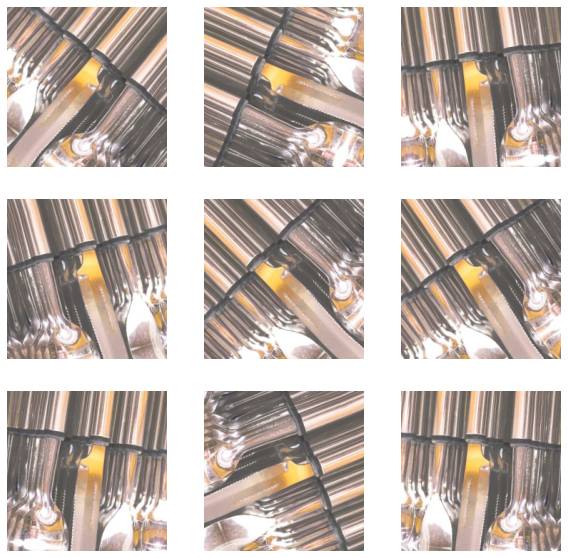

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(64, 7, 7, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(32)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(64, 32)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
#compiling the model
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, 
                                                                 name='sparse_categorical_crossentropy'),
              metrics=['accuracy'])

In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                40992 

In [ ]:
len(model.trainable_variables)


2

In [ ]:
#training the model
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)


4/4 [==============================] - 46s 164ms/step - loss: 12.3808 - accuracy: 0.0000e+00


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 12.38
initial accuracy: 0.00


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/20
13/13 [==============================] - 27s 2s/step - loss: 8.5107 - accuracy: 0.1027 - val_loss: 5.7982 - val_accuracy: 0.1388
Epoch 2/20
13/13 [==============================] - 4s 172ms/step - loss: 4.3678 - accuracy: 0.2172 - val_loss: 3.4900 - val_accuracy: 0.2632
Epoch 3/20
13/13 [==============================] - 3s 172ms/step - loss: 3.8768 - accuracy: 0.2523 - val_loss: 3.7147 - val_accuracy: 0.2584
Epoch 4/20
13/13 [==============================] - 3s 170ms/step - loss: 4.3124 - accuracy: 0.2276 - val_loss: 4.3546 - val_accuracy: 0.2967
Epoch 5/20
13/13 [==============================] - 3s 170ms/step - loss: 4.2288 - accuracy: 0.2744 - val_loss: 4.1561 - val_accuracy: 0.3541
Epoch 6/20
13/13 [==============================] - 3s 165ms/step - loss: 3.9770 - accuracy: 0.3134 - val_loss: 3.6641 - val_accuracy: 0.3923
Epoch 7/20
13/13 [==============================] - 3s 166ms/step - loss: 3.6495 - accuracy: 0.4525 - val_loss: 4.0272 - val_accuracy: 0.4545
Epoch 8/

Text(0.5, 1.0, 'Training and Validation Accuracy')

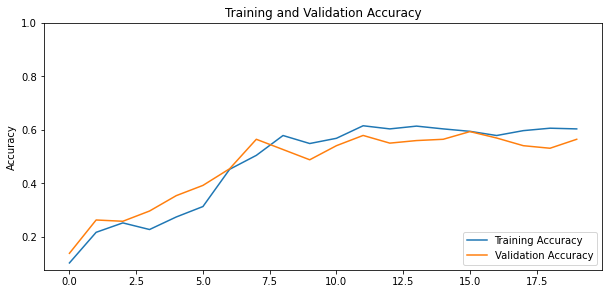

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')




Predictions:
 [0 0 0 ... 0 0 0]
Labels:
 [9 3 2 9 4 3 0 5 6 5 1 5 7 3 4 8 5 1 8 3 6 4 7 1 6 1 7 4 4 2 9 3 8 4 5 1 0
 0 6 1 1 4 9 1 1 8 2 2 7 5 2 8 4 2 6 7 0 4 6 7 4 0 5 5]


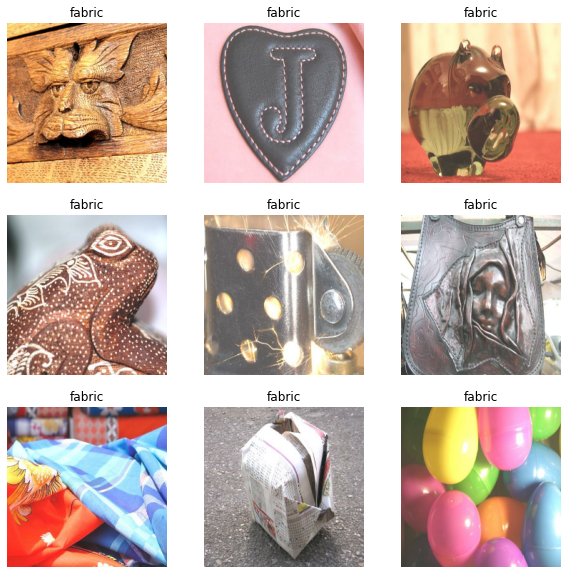

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.softmax(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")